In [1]:
import math
import noise_scheduler

import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm.auto import tqdm
import pandas as pd

from sklearn.datasets import make_moons
from torch.utils.data import TensorDataset

import ddpm_Time_Series_copy
from ddpm_Time_Series_copy import TimeSeriesDataset

from torch.utils.data import Dataset, DataLoader
import argparse
import os

from torch import nn
from torch.nn import functional as F

from positional_embeddings import PositionalEmbedding

/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [39]:
class Config:
    def __init__(self, config_dict):
        for key, value in config_dict.items():
            setattr(self, key, value)

config = {
  "data_path": "../datasets/UTS/NAB/Twitter_volume_AAPL",
  "output_dir": "output",
  "train_batch_size": 16,
  "eval_batch_size": 16,
  "num_epochs": 1,
  
  "learning_rate": 0.0001,
  "num_timesteps": 100,
  "beta_schedule": "quadratic",
  "embedding_size": 128,
  "hidden_size": 128,
  "hidden_layers": 3,
  "time_embedding": "sinusoidal",
  "input_embedding": "sinusoidal",
  "save_eval_step": 10,
  "experiment_name": "NonName",
  "beta_start": 0.05,
  "beta_end": 0.3,
  "save_model_epochs": 1
}


# Create Config object
config = Config(config)



In [31]:
dataset = TimeSeriesDataset(config.data_path,sequence_length=5000, stride=1,normalize=False)

dataloader = DataLoader(dataset, batch_size=config.train_batch_size, shuffle=False , drop_last=True)

# White Gaussian Noise classic 

In [40]:
from noise_scheduler import NoiseScheduler

  0%|          | 0/184 [00:00<?, ?it/s]

0
tensor([[104., 100.,  99.,  ...,  75.,  74.,  54.],
        [100.,  99., 154.,  ...,  74.,  54.,  94.],
        [ 99., 154., 120.,  ...,  54.,  94.,  51.],
        ...,
        [245., 166., 139.,  ...,  31.,  46.,  36.],
        [166., 139., 112.,  ...,  46.,  36.,  33.],
        [139., 112.,  95.,  ...,  36.,  33.,  48.]])
tensor([[0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        ...,
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.]], dtype=torch.float64)
timesteps tensor([44, 99,  1, 22, 39, 45, 44, 75, 32, 45, 66, 69, 22, 68, 73, 22])
Batch shape: torch.Size([16, 5000])
Noise shape: torch.Size([16, 5000])
Noisy shape: torch.Size([16, 5000])
tensor([-0.1733,  0.0857,  0.1077,  ...,  1.8536,  0.4144, -0.4256])
tensor([-0.1733,  0.0857,  0.1077,  ...,  1.8536,  0.4144, -0.4256])
tensor([-0.1733,  0.0857,  0.1077,  ...,  1.8536,  0.4144, -0.4256])

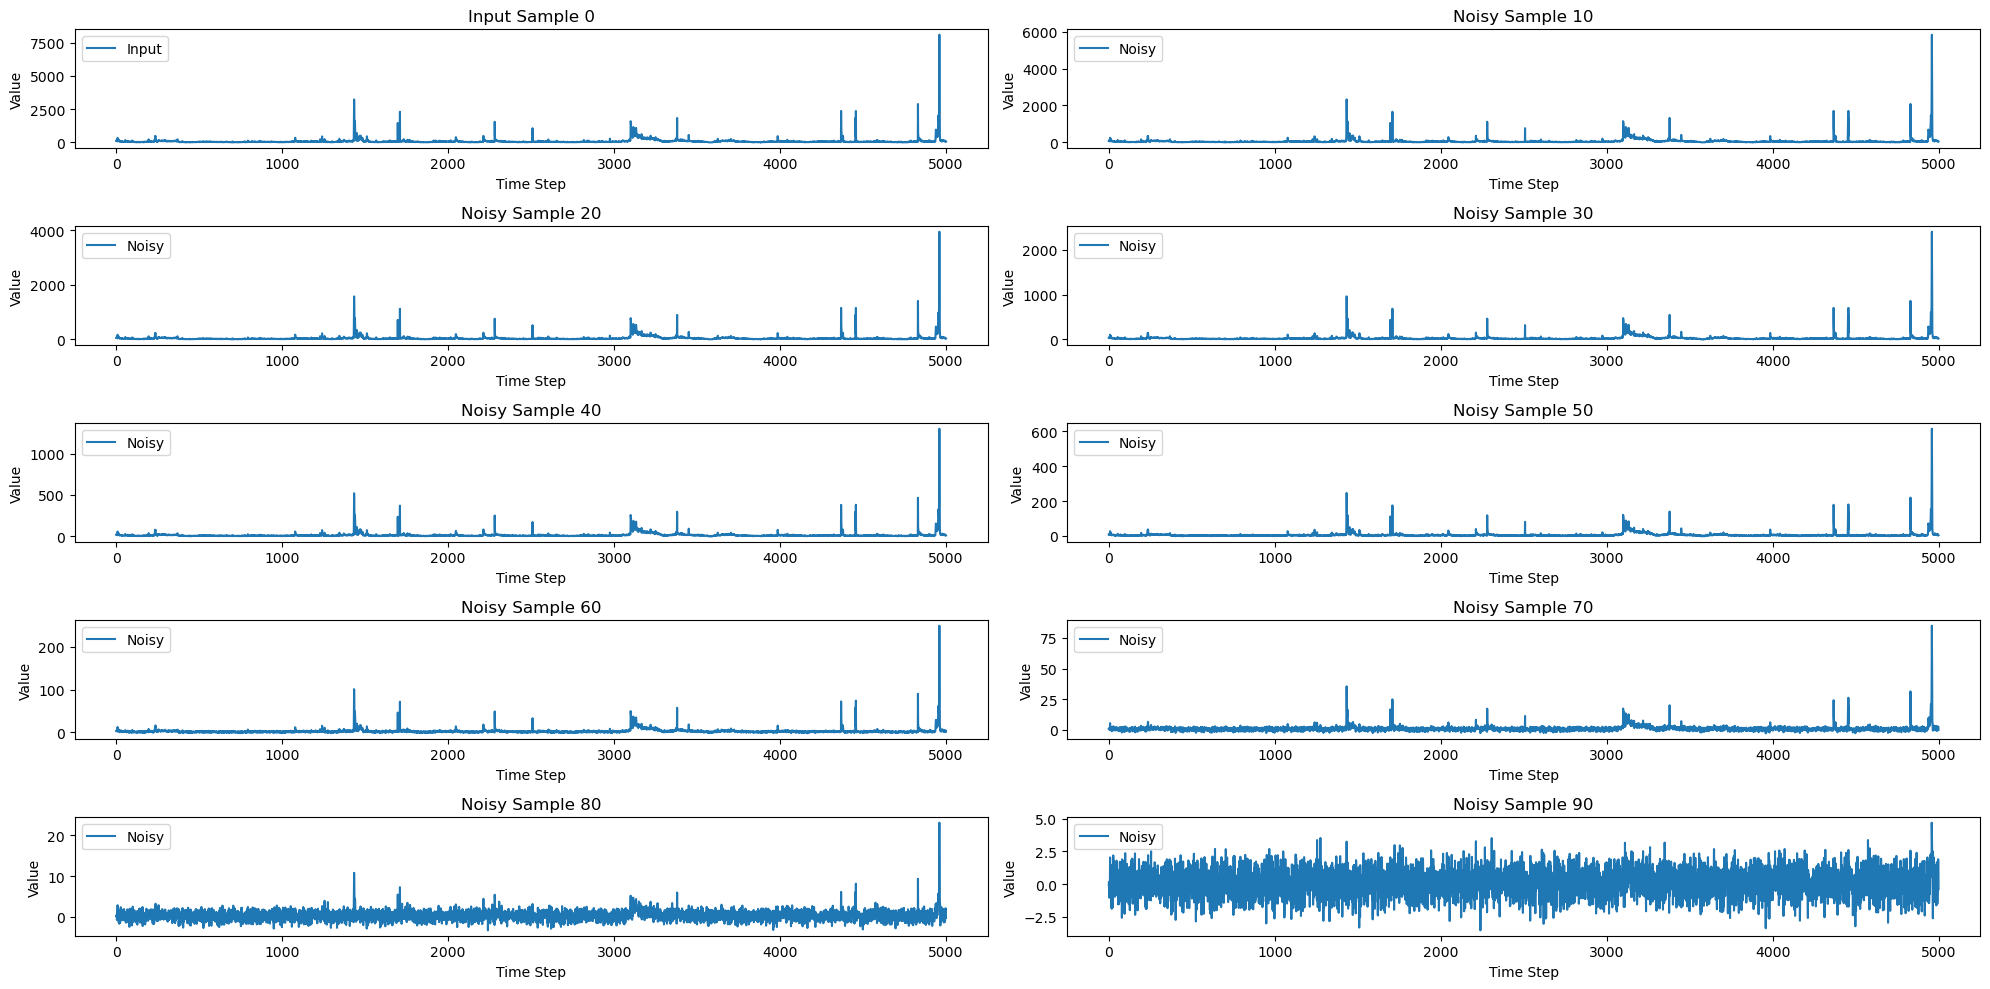

Showing input and noisy data


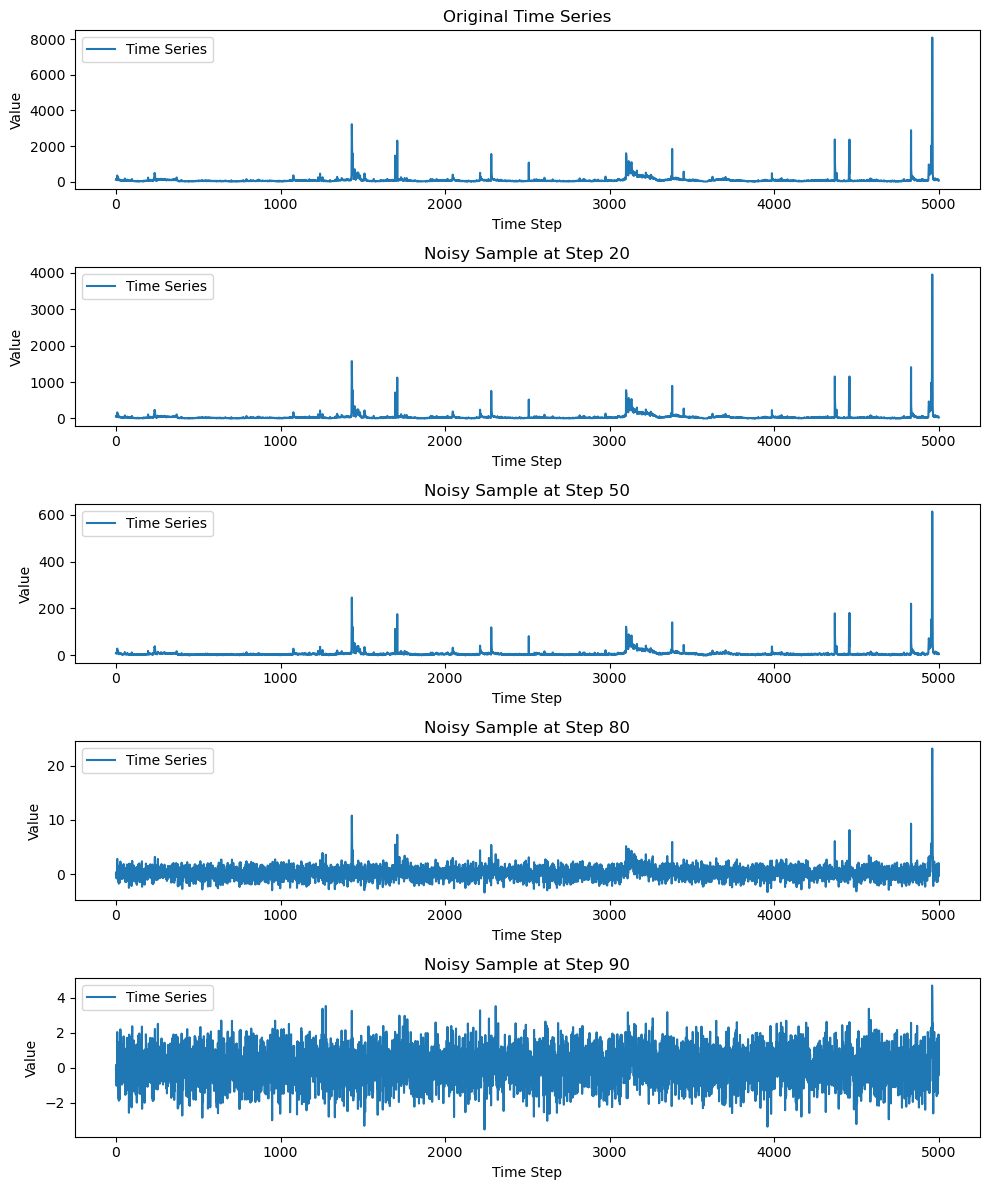

Epoch 0:   0%|          | 0/184 [00:00<?, ?it/s]

Showing original and noisy data


In [41]:

noise_scheduler = NoiseScheduler(
    num_timesteps=config.num_timesteps,
    beta_start=config.beta_start,
    beta_end=config.beta_end,
    beta_schedule=config.beta_schedule
)

for epoch in range(config.num_epochs):
    progress_bar = tqdm(total=len(dataloader))
    progress_bar.set_description(f"Epoch {epoch}")
    
    for step, (batch,  labels) in enumerate(tqdm(dataloader)):
        #batch = batch.unsqueeze(-1)  # Add channel dimension: (batch_size, sequence_length, 1)
        
        std_batch = batch.std(dim=1, keepdim=True)
        
        print(step)
        print(batch)
        print(labels)
        
        noise = torch.randn_like(batch) #*std_batch
        
        timesteps = torch.randint(
            0, noise_scheduler.num_timesteps, (batch.shape[0],)
        ).long()
        
        print('timesteps', timesteps)

        noisy = noise_scheduler.add_noise(batch, noise, timesteps)
        
        print(f"Batch shape: {batch.shape}")
        print(f"Noise shape: {noise.shape}")
        print(f"Noisy shape: {noisy.shape}")
        

        # Visualize the input and noisy data 
        fig, axs = plt.subplots(5, 2, figsize=(20, 10))
        
        # Plotting the first sample
        ax = axs[0, 0]
        ax.plot(batch[0].cpu().numpy())
        ax.set_title("Input Sample 0")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Value")
        ax.legend(["Input"])


        # Plotting noisy versions of the first sample
        for i in range(9):
            print( noise[0])
            noisy_sample = noise_scheduler.add_noise(batch[0], noise[0], torch.tensor([(i+1)*10]))
            
            ax = axs[(i+1) // 2, (i+1) % 2]
            ax.plot(noisy_sample[0].cpu().numpy())
            ax.set_title(f"Noisy Sample {(i+1)*10}")
            ax.set_xlabel("Time Step")
            ax.set_ylabel("Value")
            ax.legend(["Noisy"])

        fig.tight_layout()
        plt.show()
        print("Showing input and noisy data")
        

        fig, axs = plt.subplots(5, 1, figsize=(10, 12))

        steps = [0, 20, 50, 80, 90]

        # Plotting noisy versions of the first sample at specified steps
        for i, step in enumerate(steps):
            if step == 0:
                # Plotting the original time series
                noisy_sample = batch[0]
                ax = axs[i]
                ax.plot(noisy_sample.cpu().numpy())
                ax.set_title("Original Time Series")
            else:
                # Plotting the noisy version
                noisy_sample = noise_scheduler.add_noise(batch[0], noise[0], torch.tensor([step]))
                ax = axs[i]
                ax.plot(noisy_sample[0].cpu().numpy())
                ax.set_title(f"Noisy Sample at Step {step}")
            
            ax.set_xlabel("Time Step")
            ax.set_ylabel("Value")
            ax.legend(["Time Series"])

        fig.tight_layout()
        plt.show()
        print("Showing original and noisy data")

        
        break
    
    progress_bar.close()



# Simplex noise

In [32]:
from noise_scheduler import SimplexNoiseScheduler

Epoch 0:   0%|          | 0/184 [00:00<?, ?it/s]

0
tensor([[104., 100.,  99.,  ...,  75.,  74.,  54.],
        [100.,  99., 154.,  ...,  74.,  54.,  94.],
        [ 99., 154., 120.,  ...,  54.,  94.,  51.],
        ...,
        [245., 166., 139.,  ...,  31.,  46.,  36.],
        [166., 139., 112.,  ...,  46.,  36.,  33.],
        [139., 112.,  95.,  ...,  36.,  33.,  48.]])
tensor([[0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        ...,
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.]], dtype=torch.float64)
timesteps tensor([ 1, 52, 46, 43, 37, 75, 19, 88, 36, 47, 82, 27, 54, 21, 68, 11])
Batch shape: torch.Size([16, 5000])
Noise shape: torch.Size([16, 5000])
Noisy shape: torch.Size([16, 5000])


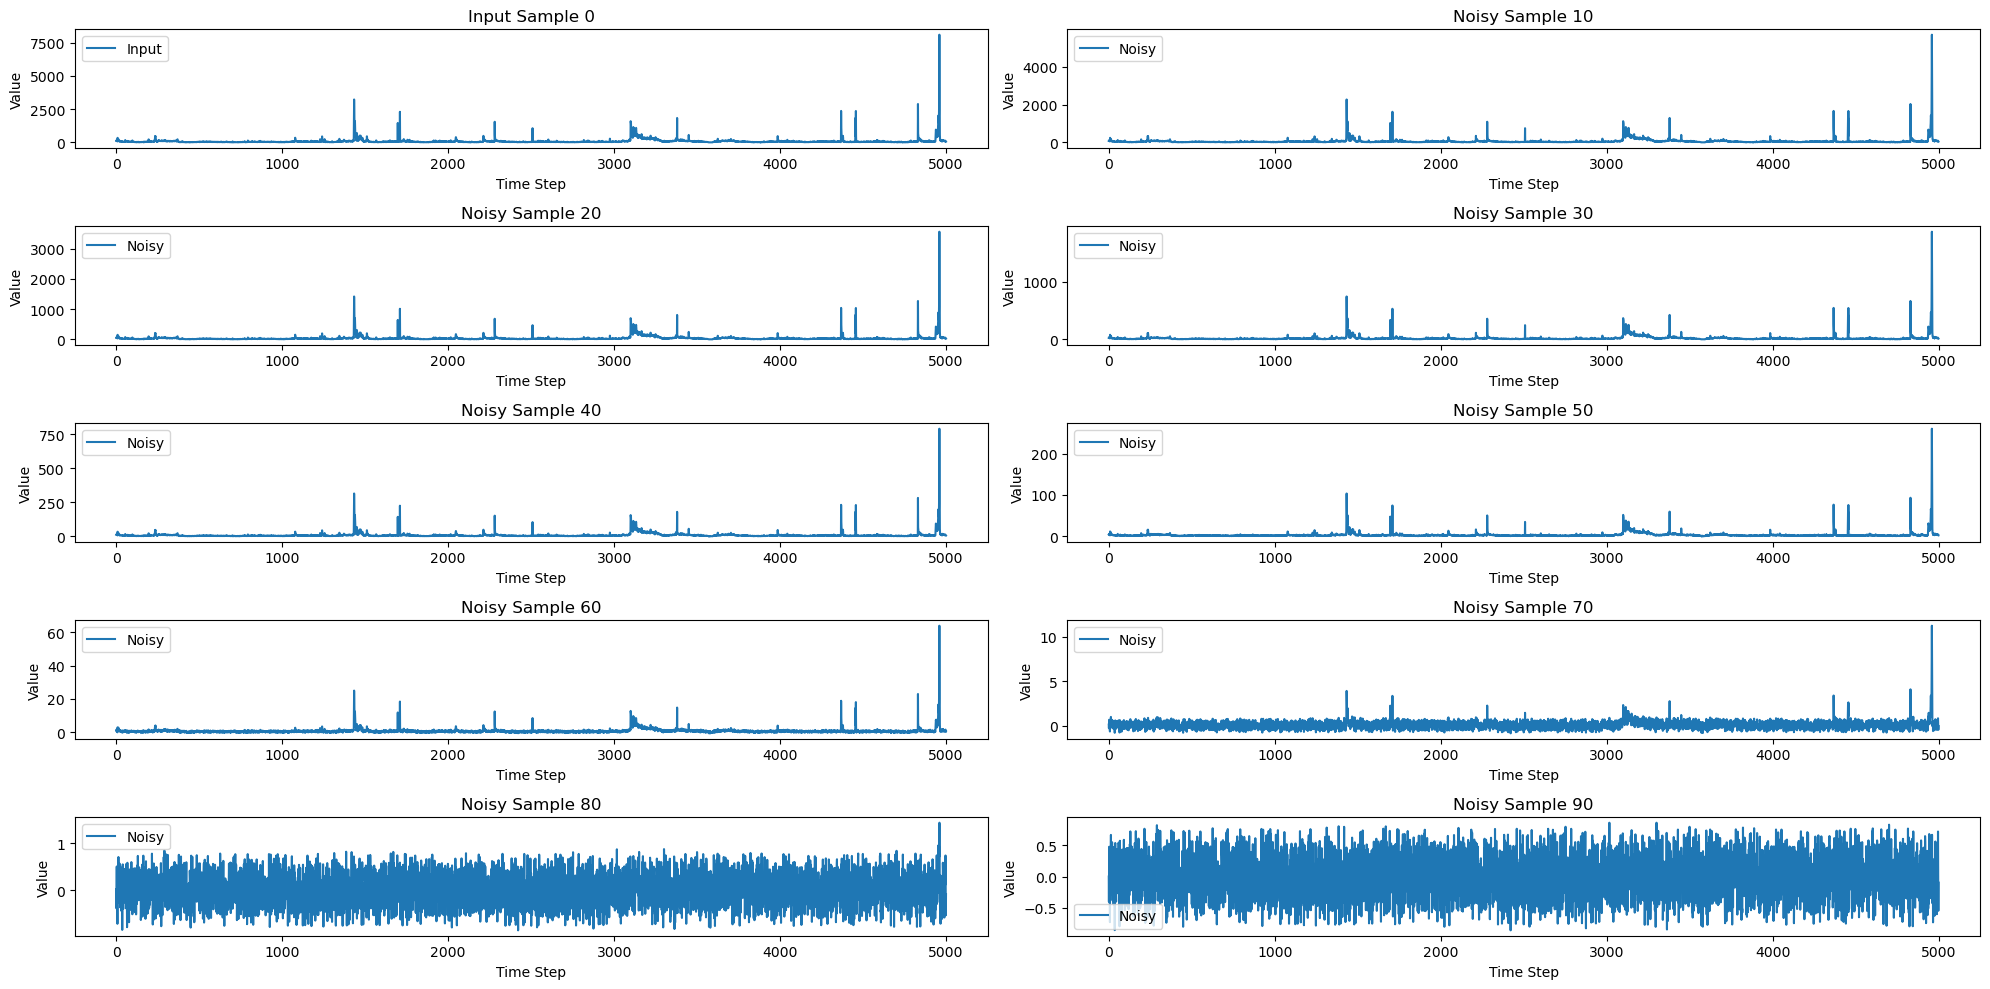

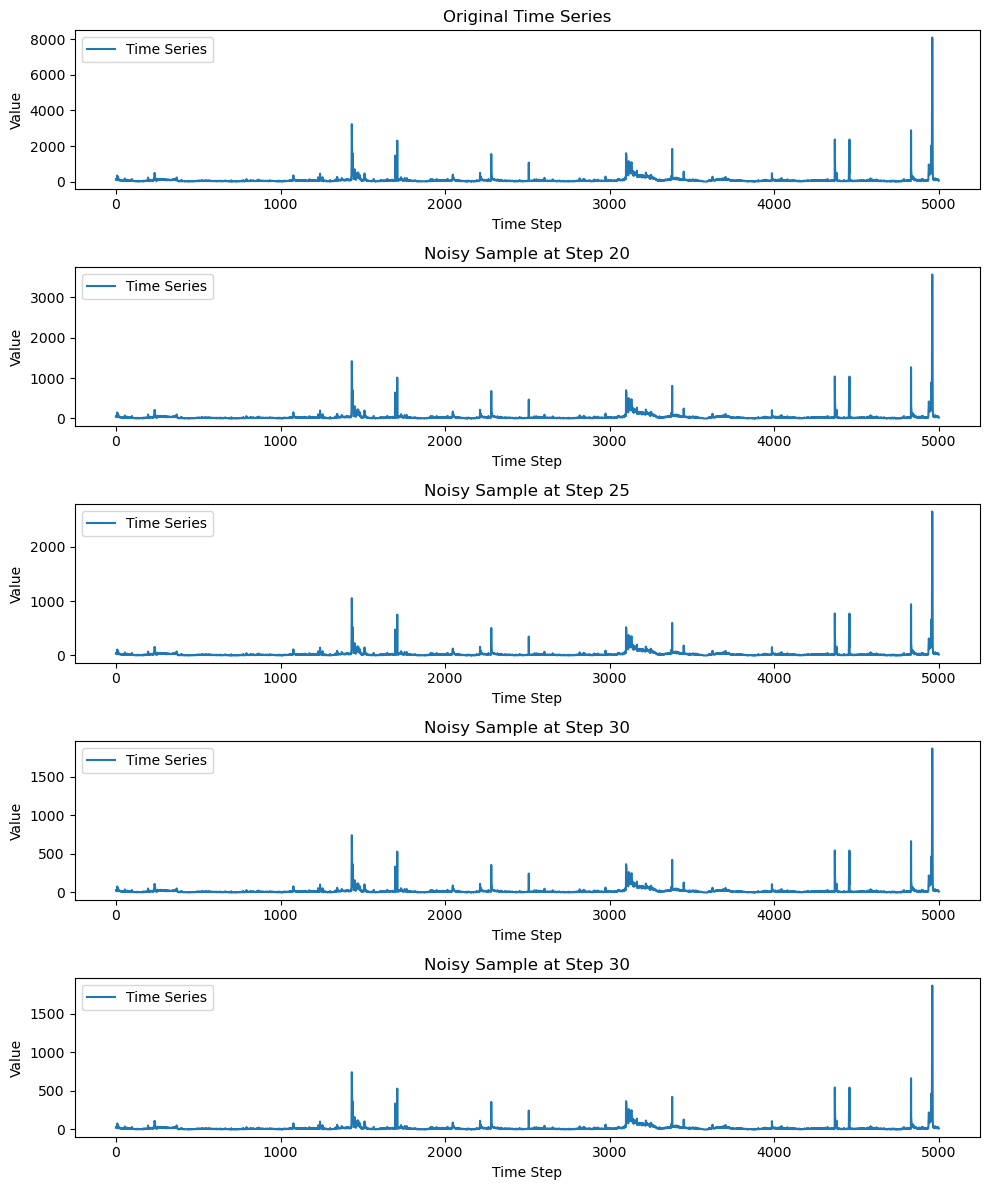

  0%|          | 0/184 [00:01<?, ?it/s]

Showing original and noisy data


In [33]:

noise_scheduler = SimplexNoiseScheduler(
    num_timesteps=config.num_timesteps,
    beta_start=config.beta_start,
    beta_end=config.beta_end,
    beta_schedule=config.beta_schedule
)

for epoch in range(config.num_epochs):

    progress_bar = tqdm(total=len(dataloader))
    progress_bar.set_description(f"Epoch {epoch}")
    
    for step, (batch,labels) in enumerate(tqdm(dataloader)):
        #batch = batch.unsqueeze(-1)  # Add channel dimension: (batch_size, sequence_length, 1)
        
        print(step)
        print(batch)
        print(labels)
        
        noise = noise_scheduler.generate_simplex_noise_like(batch)
        
        timesteps = torch.randint(
            0, noise_scheduler.num_timesteps, (batch.shape[0],)
        ).long()
        
        print('timesteps', timesteps)

        noisy = noise_scheduler.add_noise(batch, noise, timesteps)
        
        print(f"Batch shape: {batch.shape}")
        print(f"Noise shape: {noise.shape}")
        print(f"Noisy shape: {noisy.shape}")
        

        # Visualize the input and noisy data 
        fig, axs = plt.subplots(5, 2, figsize=(20, 10))
        
        # Plotting the first sample
        ax = axs[0, 0]
        ax.plot(batch[0].cpu().numpy())
        ax.set_title("Input Sample 0")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Value")
        ax.legend(["Input"])

        # Plotting noisy versions of the first sample
        for i in range(9):
            noisy_sample = noise_scheduler.add_noise(batch[0], noise[0], torch.tensor([(i+1)*10]))
            ax = axs[(i+1) // 2, (i+1) % 2]
            ax.plot(noisy_sample[0].cpu().numpy())
            ax.set_title(f"Noisy Sample {(i+1)*10}")
            ax.set_xlabel("Time Step")
            ax.set_ylabel("Value")
            ax.legend(["Noisy"])

        fig.tight_layout()
        plt.show()
        
        fig, axs = plt.subplots(5, 1, figsize=(10, 12))

        steps = [0, 20, 25, 30, 30]

        # Plotting noisy versions of the first sample at specified steps
        for i, step in enumerate(steps):
            if step == 0:
                # Plotting the original time series
                noisy_sample = batch[0]
                ax = axs[i]
                ax.plot(noisy_sample.cpu().numpy())
                ax.set_title("Original Time Series")
            else:
                # Plotting the noisy version
                noisy_sample = noise_scheduler.add_noise(batch[0], noise[0], torch.tensor([step]))
                ax = axs[i]
                ax.plot(noisy_sample[0].cpu().numpy())
                ax.set_title(f"Noisy Sample at Step {step}")
            
            ax.set_xlabel("Time Step")
            ax.set_ylabel("Value")
            ax.legend(["Time Series"])

        fig.tight_layout()
        plt.show()
        print("Showing original and noisy data")

        break

# Pink noise 

In [37]:
from noise_scheduler import PinkNoiseScheduler

Epoch 0:   0%|          | 0/184 [00:00<?, ?it/s]

0
tensor([[104., 100.,  99.,  ...,  75.,  74.,  54.],
        [100.,  99., 154.,  ...,  74.,  54.,  94.],
        [ 99., 154., 120.,  ...,  54.,  94.,  51.],
        ...,
        [245., 166., 139.,  ...,  31.,  46.,  36.],
        [166., 139., 112.,  ...,  46.,  36.,  33.],
        [139., 112.,  95.,  ...,  36.,  33.,  48.]])
tensor([[0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        ...,
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.]], dtype=torch.float64)
timesteps tensor([55, 42, 10, 82, 67, 53, 29, 89,  8, 77, 47, 94, 14, 46, 24, 31])
Batch shape: torch.Size([16, 5000])
Noise shape: torch.Size([16, 5000])
Noisy shape: torch.Size([16, 5000])


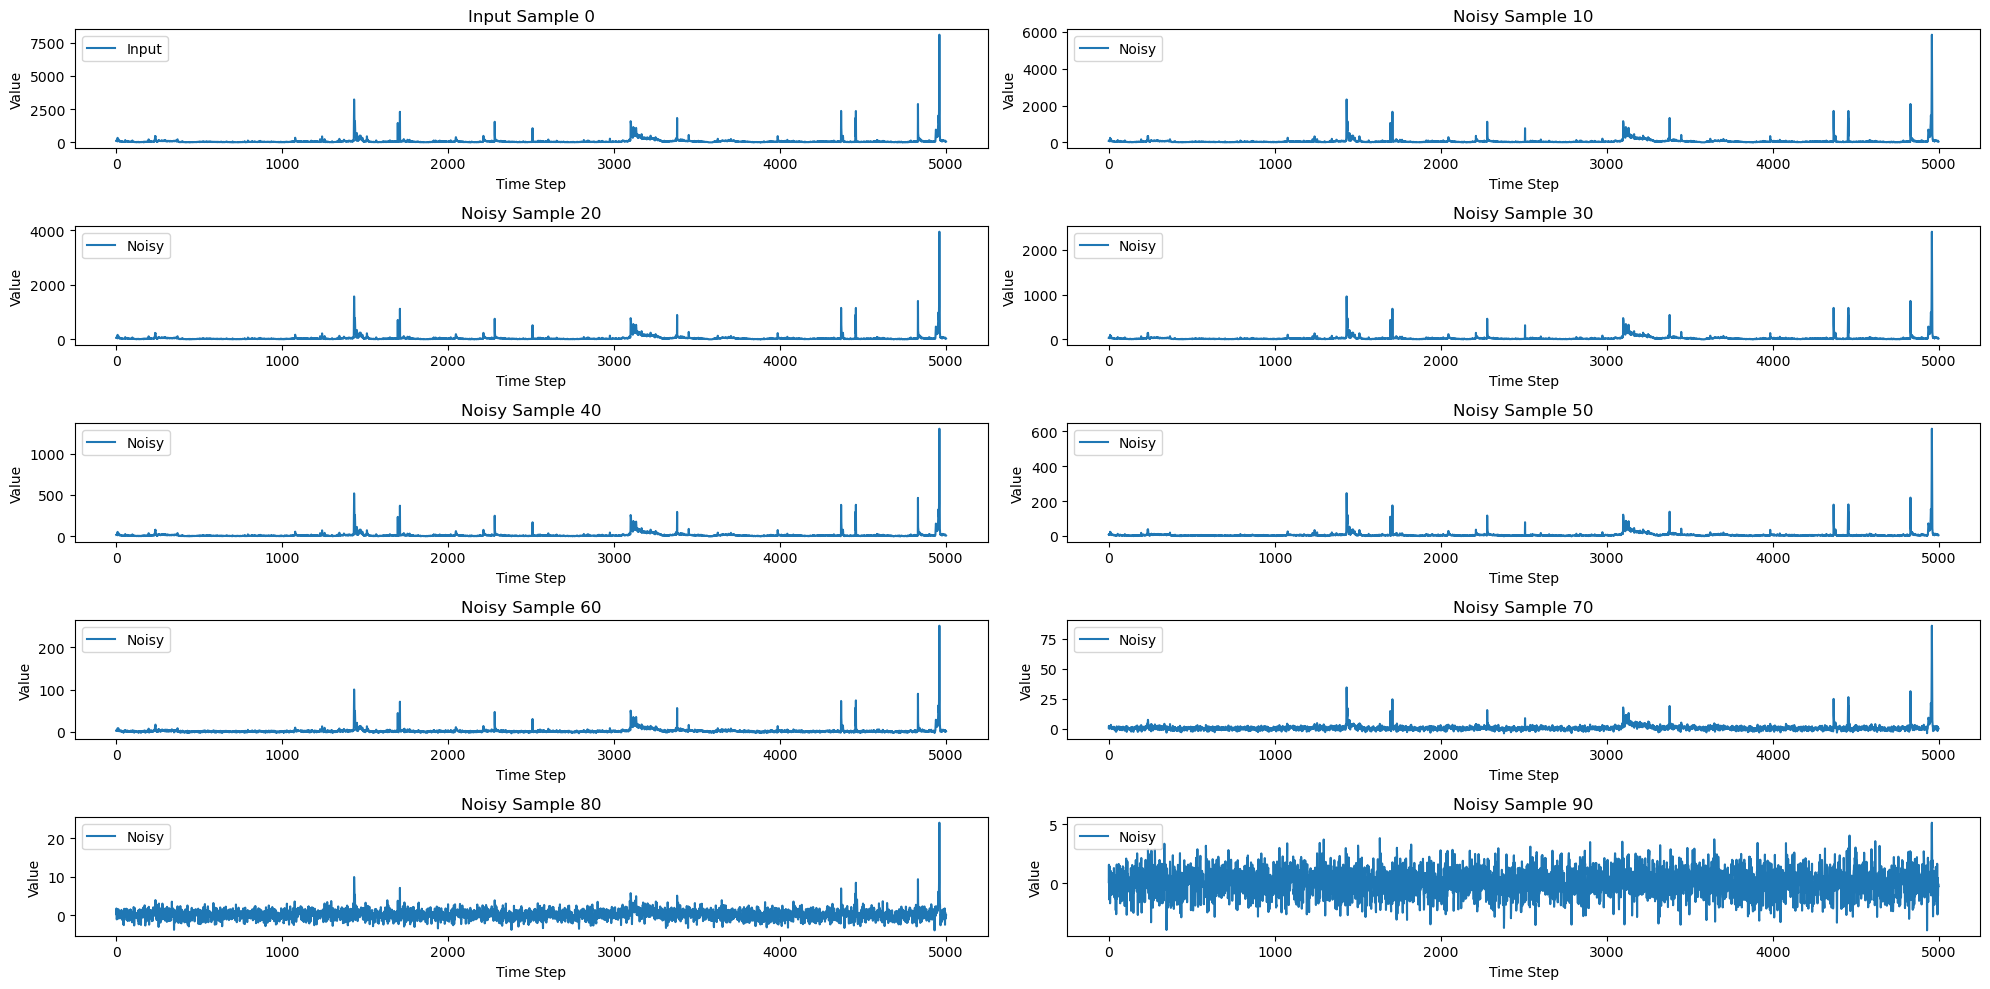

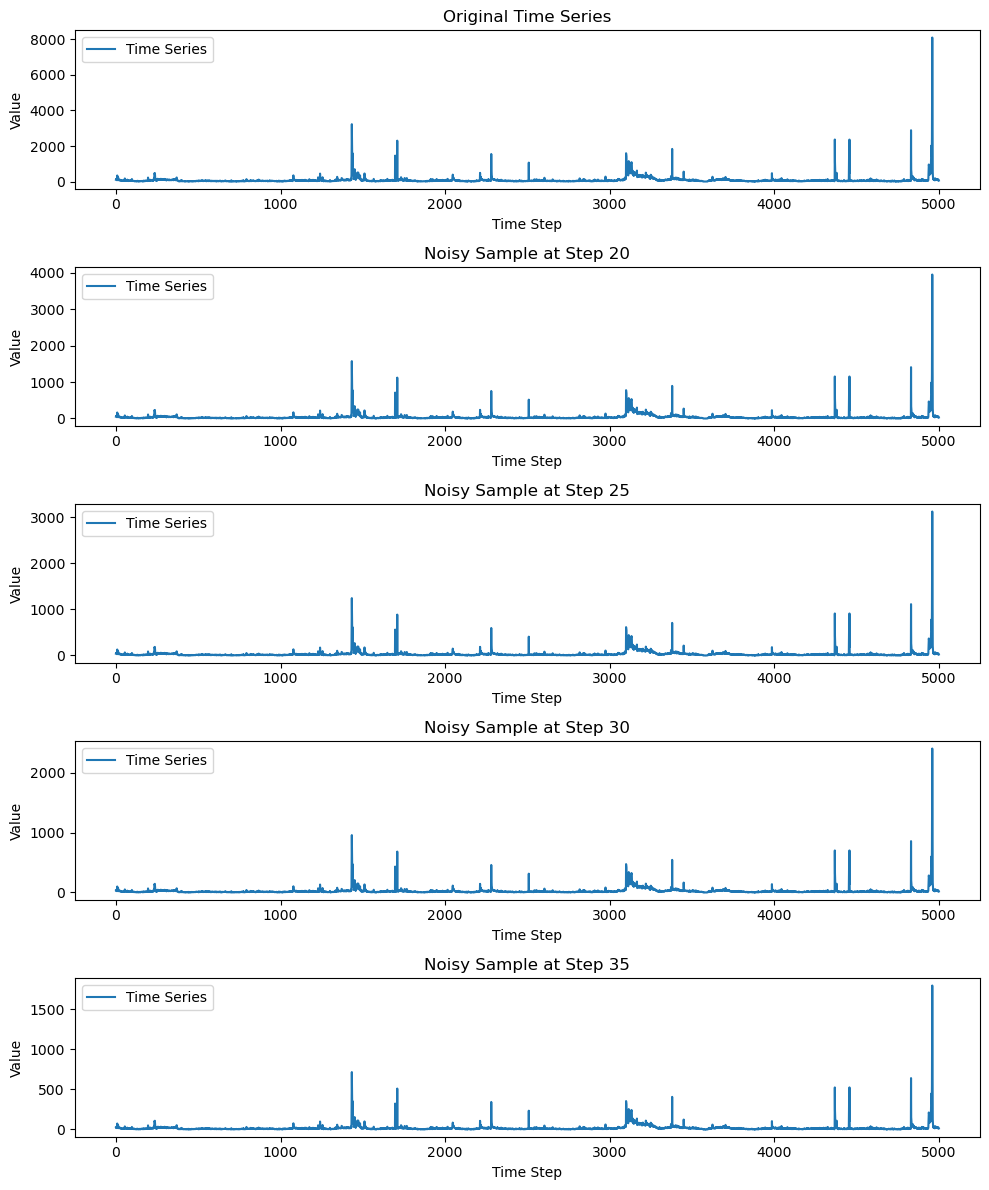

  0%|          | 0/184 [00:00<?, ?it/s]

Showing original and noisy data


In [38]:

noise_scheduler = PinkNoiseScheduler(
    num_timesteps=config.num_timesteps,
    beta_start=config.beta_start,
    beta_end=config.beta_end,
    beta_schedule=config.beta_schedule
)

for epoch in range(config.num_epochs):

    progress_bar = tqdm(total=len(dataloader))
    progress_bar.set_description(f"Epoch {epoch}")
    
    for step, (batch,  labels) in enumerate(tqdm(dataloader)):
        #batch = batch.unsqueeze(-1)  # Add channel dimension: (batch_size, sequence_length, 1)
        
        print(step)
        print(batch)
        print(labels)
        
        noise = noise_scheduler.generate_pink_noise_like(batch)
        
        timesteps = torch.randint(
            0, noise_scheduler.num_timesteps, (batch.shape[0],)
        ).long()
        
        print('timesteps', timesteps)

        noisy = noise_scheduler.add_noise(batch, noise, timesteps)
        
        print(f"Batch shape: {batch.shape}")
        print(f"Noise shape: {noise.shape}")
        print(f"Noisy shape: {noisy.shape}")
        

        # Visualize the input and noisy data 
        fig, axs = plt.subplots(5, 2, figsize=(20, 10))
        
        # Plotting the first sample
        ax = axs[0, 0]
        ax.plot(batch[0].cpu().numpy())
        ax.set_title("Input Sample 0")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Value")
        ax.legend(["Input"])

        # Plotting noisy versions of the first sample
        for i in range(9):
            noisy_sample = noise_scheduler.add_noise(batch[0], noise[0], torch.tensor([(i+1)*10]))
            ax = axs[(i+1) // 2, (i+1) % 2]
            ax.plot(noisy_sample[0].cpu().numpy())
            ax.set_title(f"Noisy Sample {(i+1)*10}")
            ax.set_xlabel("Time Step")
            ax.set_ylabel("Value")
            ax.legend(["Noisy"])

        fig.tight_layout()
        plt.show()
        fig, axs = plt.subplots(5, 1, figsize=(10, 12))

        steps = [0, 20, 25, 30, 35]

        # Plotting noisy versions of the first sample at specified steps
        for i, step in enumerate(steps):
            if step == 0:
                # Plotting the original time series
                noisy_sample = batch[0]
                ax = axs[i]
                ax.plot(noisy_sample.cpu().numpy())
                ax.set_title("Original Time Series")
            else:
                # Plotting the noisy version
                noisy_sample = noise_scheduler.add_noise(batch[0], noise[0], torch.tensor([step]))
                ax = axs[i]
                ax.plot(noisy_sample[0].cpu().numpy())
                ax.set_title(f"Noisy Sample at Step {step}")
            
            ax.set_xlabel("Time Step")
            ax.set_ylabel("Value")
            ax.legend(["Time Series"])

        fig.tight_layout()
        plt.show()
        print("Showing original and noisy data")

        break